In [1]:
# Imports to start with

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats

In [ ]:
DATA_DIR = '/data' # you might need to change the directory

activity = pd.read_csv(f'{DATA_DIR}/activity.csv')

In [4]:
# cast the date column to datetime
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

# Create a column for acttivity started date only the day
activity['activity_started_date'] = pd.to_datetime(activity['activity_started'].dt.date)

# Drop duplicates in user_id, activity_started_date
activity.drop_duplicates(subset=['user_id', 'activity_started_date'], inplace=True)

display(activity.head())
print(activity['activity_started_date'].nunique())

,Unnamed: 0,activity_id,user_id,post_id,course_id,activity_type,activity_status,activity_started,activity_completed,activity_updated,activity_started_date
0,75,1111,2533,1696,1696,access,0,2023-04-07 16:16:41,NaT,2023-04-07 16:16:41,2023-04-07
16,91,1127,2533,42,42,access,0,2023-07-21 14:38:57,1970-01-01,2023-04-07 16:42:11,2023-07-21
35,114,1195,2533,2019,2019,course,0,2023-04-28 11:59:56,NaT,2023-04-28 11:59:56,2023-04-28
38,119,1207,2533,2115,2115,access,0,2023-05-02 08:49:46,1970-01-01,2023-05-02 08:49:46,2023-05-02
44,141,1254,2533,2211,2019,lesson,0,2023-05-06 14:25:30,NaT,2023-05-06 14:25:30,2023-05-06


415


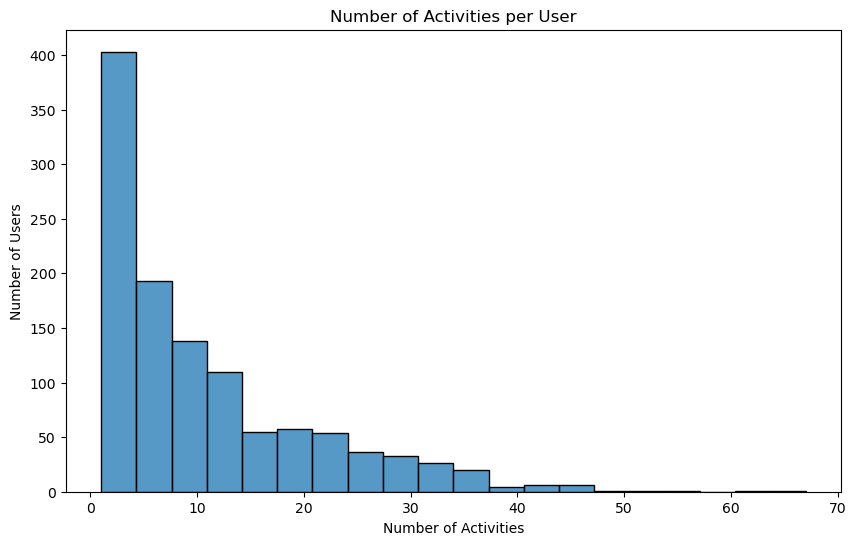

In [5]:
# Histogram of number of activities per user
plt.figure(figsize=(10, 6))
sns.histplot(activity['user_id'].value_counts(), bins=20)
plt.title('Number of Activities per User')
plt.xlabel('Number of Activities')
plt.ylabel('Number of Users')
plt.show()

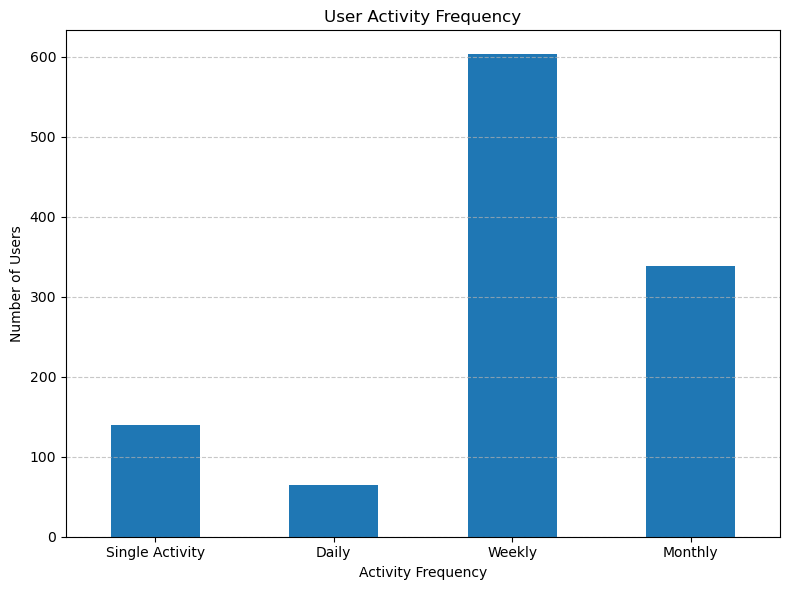

In [6]:
# Sort and calculate gaps
df = activity.sort_values(['user_id', 'activity_started_date'])
df['prev_date'] = df.groupby('user_id')['activity_started_date'].shift(1)
df['gap_days'] = (df['activity_started_date'] - df['prev_date']).dt.days

# Calculate median gap per user
user_gaps = df.groupby('user_id')['gap_days'].median().reset_index()

# Categorize users by activity frequency
def categorize(gap):
    if pd.isna(gap):
        return 'Single Activity'
    elif gap <= 1:
        return 'Daily'
    elif gap <= 7:
        return 'Weekly'
    else:
        return 'Monthly'

user_gaps['frequency'] = user_gaps['gap_days'].apply(categorize)

# Sort the frequency categories
frequency_order = ['Single Activity', 'Daily', 'Weekly', 'Monthly']
user_gaps['frequency'] = pd.Categorical(user_gaps['frequency'], categories=frequency_order, ordered=True)

# Count users per frequency category
frequency_counts = user_gaps['frequency'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(8, 6))
frequency_counts.plot(kind='bar')
plt.title('User Activity Frequency')
plt.xlabel('Activity Frequency')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
# Keep only rows where user_id exists at least 10 times in the df
user_counts = activity['user_id'].value_counts()
user_counts = user_counts[user_counts >= 15]
activity_ten = activity[activity['user_id'].isin(user_counts.index)]

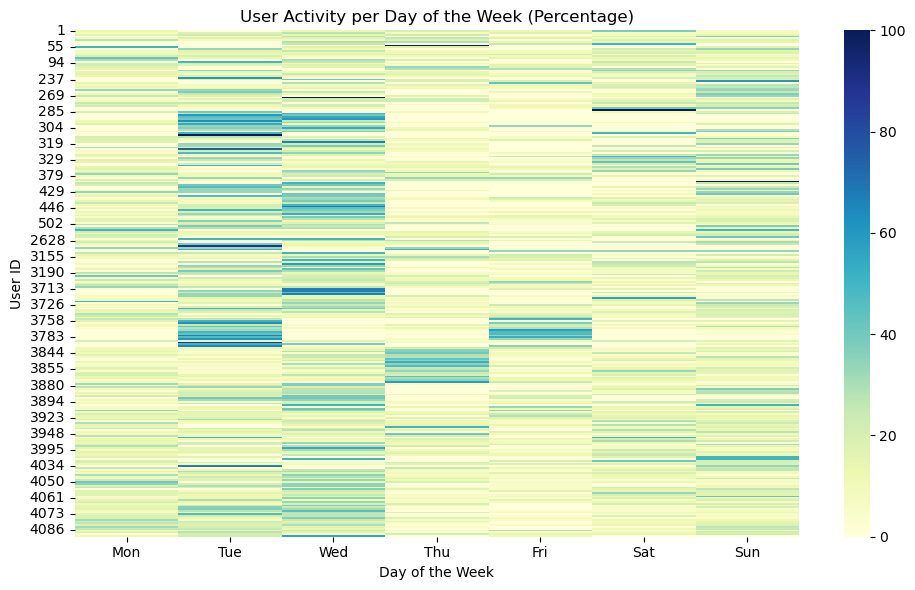

In [20]:
# Extract day of week (0=Monday, 6=Sunday)
df['day_of_week'] = activity_ten['activity_started_date'].dt.dayofweek

# Count activity per user per day of week
activity_per_day = df.groupby(['user_id', 'day_of_week']).size().unstack(fill_value=0)

# Sort columns so they align from Monday (0) to Sunday (6)
activity_per_day = activity_per_day.reindex(columns=range(7), fill_value=0)

# Rename columns for clarity
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
activity_per_day.columns = day_names

# Normalize activity counts by row (user-wise)
activity_per_day_normalized = activity_per_day.div(activity_per_day.sum(axis=1), axis=0) * 100

# Create heatmap with percentages
plt.figure(figsize=(10, 6))
sns.heatmap(activity_per_day_normalized, cmap='YlGnBu', annot=False)
plt.title('User Activity per Day of the Week (Percentage)')
plt.xlabel('Day of the Week')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your dataframe `df` with columns: user_id, activity_id, activity_started_date
# Assume df is already loaded

# Step 1: Keep only data from 2024 onward
df['activity_started_date'] = pd.to_datetime(activity['activity_started_date'])
df = df[df['activity_started_date'].dt.year >= 2024]

# Step 2: Compute the gap between each activity per user
df = df.sort_values(by=['user_id', 'activity_started_date'])
df['gap'] = df.groupby('user_id')['activity_started_date'].diff().dt.days
df = df.dropna()

# Step 3: Create sliding window features using last 10 gaps
def create_sliding_features(df, window_size=10):
    X, y, users = [], [], []
    for user_id, group in df.groupby('user_id'):
        gaps = group['gap'].values
        if len(gaps) >= window_size + 1:
            for i in range(window_size, len(gaps)):
                X.append(gaps[i-window_size:i])
                y.append(gaps[i])
                users.append(user_id)
    return np.array(X), np.array(y), np.array(users)

X, y, user_ids = create_sliding_features(df)

# Step 4: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Evaluate model
y_pred = model.predict(X_val)
print("Validation Scores:")
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MSE:", mean_squared_error(y_val, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("R2 Score:", r2_score(y_val, y_pred))


Validation Scores:
MAE: 5.414051252768549
MSE: 60.33990524785231
RMSE: 7.7678764954041535
R2 Score: -0.18172871139063318


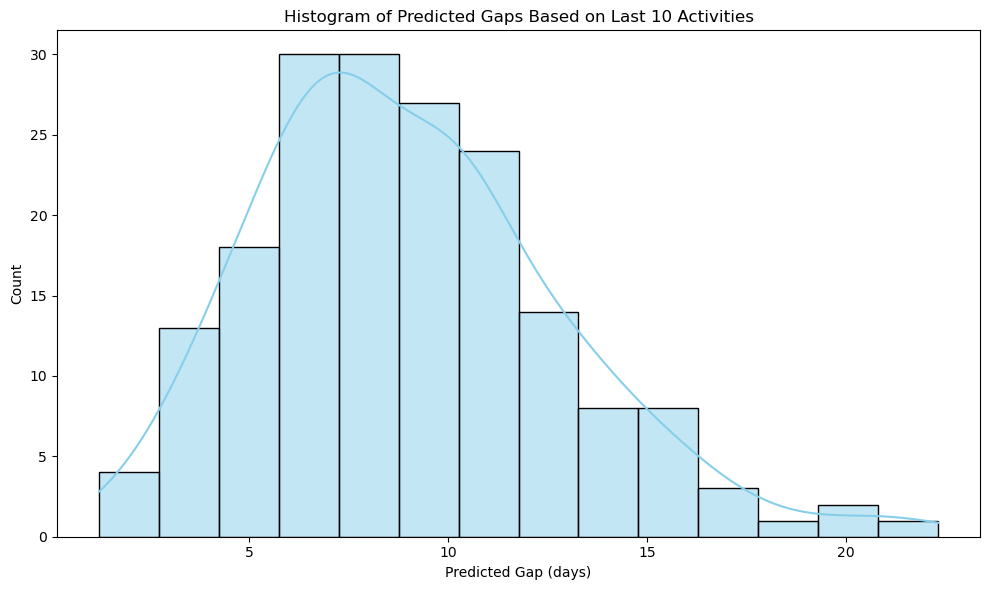

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Predict next gaps for all users using their last 10 gaps
all_predicted_gaps = []

# drop duplicates in user_id, keep last activity
df = df.drop_duplicates(subset=['user_id', 'activity_started_date'], keep='last')

for user_id in df['user_id'].unique():
    user_data = df[df['user_id'] == user_id].sort_values(by='activity_started_date')
    gaps = user_data['gap'].values
    if len(gaps) >= 10:
        recent_gaps = gaps[-10:]
        predicted_gap = model.predict([recent_gaps])[0]
        all_predicted_gaps.append(predicted_gap)

# Plot histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(all_predicted_gaps, kde=True, color='skyblue')
plt.title("Histogram of Predicted Gaps Based on Last 10 Activities")
plt.xlabel("Predicted Gap (days)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

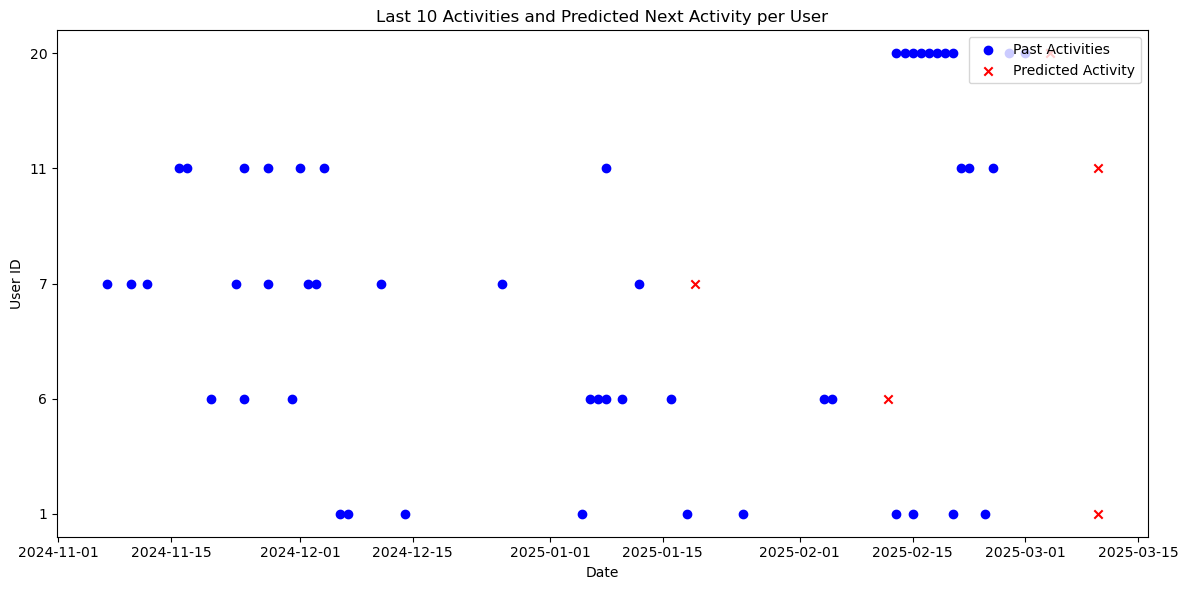

In [24]:
# Step 7: Predict next gap per user
predicted_next_dates = []
last_dates = []
number_of_users = 5
selected_users = df['user_id'].unique()[:number_of_users]

for user_id in selected_users:
    user_data = df[df['user_id'] == user_id].sort_values(by='activity_started_date')
    recent_gaps = user_data['gap'].values[-10:]
    if len(recent_gaps) == 10:
        next_gap = model.predict([recent_gaps])[0]
        last_date = user_data['activity_started_date'].iloc[-1]
        predicted_date = last_date + timedelta(days=int(round(next_gap)))
        predicted_next_dates.append(predicted_date)
        last_dates.append(last_date)

# Step 8: Scatter plot
plt.figure(figsize=(12, 6))
for idx, user_id in enumerate(selected_users):
    user_data = df[df['user_id'] == user_id].sort_values(by='activity_started_date')
    last_dates_10 = user_data['activity_started_date'].iloc[-10:]
    predicted_date = predicted_next_dates[idx]
    
    # Plot last 10 activity dates
    plt.scatter(last_dates_10, [idx]*10, marker='o', color='blue')
    
    # Plot predicted next activity date
    plt.scatter(predicted_date, idx, marker='x', color='red')

# Dummy plots for the legend
plt.scatter([], [], marker='o', color='blue', label='Past Activities')
plt.scatter([], [], marker='x', color='red', label='Predicted Activity')

# Formatting
plt.yticks(range(len(selected_users)), selected_users)
plt.xlabel("Date")
plt.ylabel("User ID")
plt.title("Last 10 Activities and Predicted Next Activity per User")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
